Import packages

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from lmfit import Model

Import all data


In [64]:
# All datasets, angles and start/end-values
datasets = {
    '5.29': {
    'file': 'C:/Natuurkunde/NSP2/Data/10cm_holle_cilinder_verbeterd.mqa',
    'start_index':226,
    'end_index':770},       
    '8.49': {
    'file':'C:/Natuurkunde/NSP2/Data/16cm_holle_cilinder.mqa',
    'start_index':216,
    'end_index':655},
    '11.71': {
    'file': 'C:/Natuurkunde/NSP2/Data/22cm_holle_cilinder.mqa',
    'start_index':194,
    'end_index':572},       
    '14.97': {
    'file':'C:/Natuurkunde/NSP2/Data/28cm_holle_cilinder.mqa',
    'start_index':169,
    'end_index':503},   
    '18.28': {
    'file':'C:/Natuurkunde/NSP2/Data/34cm_holle_cilinder.mqa',
    'start_index':164,
    'end_index':465},
    '21.65': {
    'file': 'C:/Natuurkunde/NSP2/Data/40cm_holle_cilinder.mqa',
    'start_index':246,
    'end_index':523},       
    '25.11': {
    'file':'C:/Natuurkunde/NSP2/Data/46cm_holle_cilinder.mqa',
    'start_index':382,
    'end_index':630},
    '28.67': {
    'file':'C:/Natuurkunde/NSP2/Data/52cm_holle_cilinder.mqa',
    'start_index':214,
    'end_index':464},
}

Error calculation x,y

In [65]:
def xy_err():
    # Import calibration data
    path = 'C:/Natuurkunde/NSP2/Data/calibratie_err_s.mqa' 
    df = pd.read_csv(path, sep='\t', header=0)

    # Assign columns
    x_position_cal = df['Point #1.X']
    y_position_cal = df['Point #1.Y']
    
    # Manually specify the begin and end indices
    start_index = 1 
    end_index = 1528

    # Slice the data based on the manually specified range
    x_position_cal_selected = x_position_cal.iloc[start_index:end_index].reset_index(drop=True)
    y_position_cal_selected = y_position_cal.iloc[start_index:end_index].reset_index(drop=True)
    
    # Find maximal and minimal values in datasets
    x_max = np.max(x_position_cal_selected)
    x_min = np.min(x_position_cal_selected)
    y_max = np.max(y_position_cal_selected)
    y_min = np.min(y_position_cal_selected)
    
    # Find error on x and y in cm
    err_x = (x_max - x_min) / 2
    err_y = (y_max - y_min) / 2
    #print(err_x, err_y)
    return err_x, err_y

Fit $a$, error calculation in loop

In [66]:
# Initialize storage for results
results = []
list_alpha = []

# Loop over each dataset
for alpha_label, dataset_info in datasets.items():
    file_path = dataset_info['file']
    start_index = dataset_info['start_index']
    end_index = dataset_info['end_index']
    
    df = pd.read_csv(file_path, sep='\t', header=0)
    
    # Extract time, x-position, and y-position
    time = df['Time']
    x_position = df['Point #1.X']
    y_position = df['Point #1.Y']
    
    # Slice the data based on the manually specified range
    time_selected = time.iloc[start_index:end_index].reset_index(drop=True)
    x_position_selected = x_position.iloc[start_index:end_index].reset_index(drop=True)
    y_position_selected = y_position.iloc[start_index:end_index].reset_index(drop=True)

    # Adjust data to start at (0, 0)
    x_position_adjusted = x_position_selected - x_position_selected.iloc[0]
    y_position_adjusted = y_position_selected - y_position_selected.iloc[0]
    time_adjusted = time_selected - time_selected.iloc[0]
    
    # Calculate distance s
    s = np.sqrt(x_position_adjusted**2 + y_position_adjusted**2)
    
    # Calculate error on s in cm
    err_s = []
    err_x, err_y = xy_err()
    for x, y in zip(x_position_adjusted, y_position_adjusted):
        if x > 0 and y < 0:
            err_s.append(np.sqrt(((x**2)/(x**2 + y**2)) * err_x + ((y**2)/(x**2 + y**2)) * err_y))
            
     # Add weights
    weights = 1 / np.array(err_s)
    
    # Ensure lengths match
    min_length = min(len(time_adjusted), len(s), len(weights))
    time_adjusted = time_adjusted[:min_length]
    s = s[:min_length]
    weights = weights[:min_length]
    
    # Define the theoretical model function for s
    def theoretical_s(t, a, t_0):
        return 0.5 * a * (t - t_0)**2
    
    # Use lmfit Model to define the model and fit the data
    model = Model(theoretical_s)
    params = model.make_params(a=1, t_0=0)  # Initial guess for parameters

    # Fit the model to the data
    try:
        result = model.fit(s, params, t=time_adjusted, weights = weights)
        fitted_a = result.params['a'].value
        a_std = result.params['a'].stderr
        reduced_chi_squared = result.redchi
    except Exception as e:
        print(f"Error fitting data for alpha {alpha_label}: {e}")
        continue
    
    alpha = float(alpha_label)
    
    list_alpha.append(float(alpha_label))
    
    # Store the result
    results.append({'alpha': alpha, 'acc': fitted_a, 'err_a':a_std, 'red. chi^2':reduced_chi_squared})

# Convert results to a DataFrame for further use
results_df = pd.DataFrame(results)

# Display the data ready for plotting
print(results_df)

   alpha         acc     err_a  red. chi^2
0   5.29   50.648506  0.077133    8.050758
1   8.49   78.674672  0.110666    5.256508
2  11.71  110.826201  0.169303    5.172125
3  14.97  142.409610  0.200224    3.525020
4  18.28  170.326809  0.343950    6.617393
5  21.65  201.883540  0.404729    5.558046
6  25.11  232.344034  0.702384   11.151402
7  28.67  264.715518  0.558513    4.596161


Plot $a$ and $\alpha$ without fit

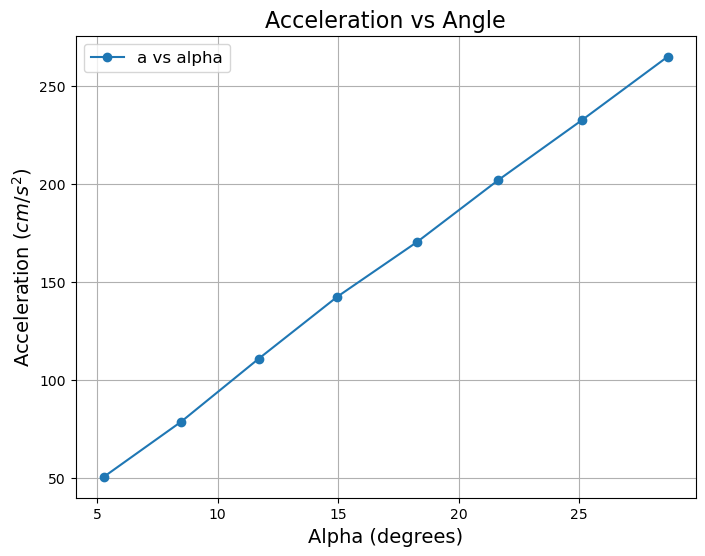

In [67]:
plt.figure(figsize=(8, 6))
plt.plot(results_df['alpha'], results_df['acc'], 'o-', label='a vs alpha')
plt.xlabel('Alpha (degrees)', fontsize=14)
plt.ylabel('Acceleration ($cm$/$s^2$)', fontsize=14)
plt.title('Acceleration vs Angle', fontsize=16)
plt.legend(fontsize=12)
plt.grid()
plt.show()

Fit $B$

In [68]:
# Gravitational constant (cm/s^2)
g = 981

# Convert alpha to radians
results_df['alpha_radians'] = np.radians(results_df['alpha'])

# Define the fitting function
def acceleration_model(alpha, B):
    return g * np.sin(alpha) / B

# Create the model
model = Model(acceleration_model)

# Perform the fit
params = model.make_params(B=1)  # Initial guess for B
result = model.fit(results_df['acc'], params, alpha=results_df['alpha_radians'], weights=1/results_df['err_a'])

# Display the fit report
print(result.fit_report())

# Extract the fitted parameter and its uncertainty
fitted_B = result.params['B'].value
fitted_B_error = result.params['B'].stderr

print(f"Fitted B: {fitted_B} ± {fitted_B_error}")

[[Model]]
    Model(acceleration_model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 8
    # variables        = 1
    chi-square         = 398.176261
    reduced chi-square = 56.8823230
    Akaike info crit   = 33.2596259
    Bayesian info crit = 33.3390674
    R-squared          = 0.98985789
[[Variables]]
    B:  1.79898757 +/- 0.00825934 (0.46%) (init = 1)
Fitted B: 1.79898756901411 ± 0.008259341906971583


Plot $a$ and $\alpha$ with fit

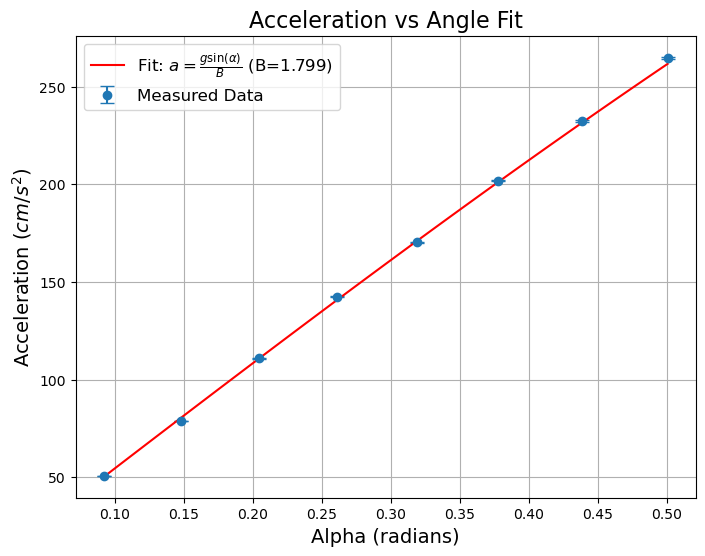

In [69]:
# Generate data for plotting the fit
alpha_fine = np.linspace(results_df['alpha_radians'].min(), results_df['alpha_radians'].max(), 100)
fitted_a = acceleration_model(alpha_fine, fitted_B)

# Plot data and the fit
plt.figure(figsize=(8, 6))
plt.errorbar(
    results_df['alpha_radians'],
    results_df['acc'],
    yerr=results_df['err_a'],
    fmt='o',
    label='Measured Data',
    capsize=5
)
plt.plot(alpha_fine, fitted_a, 'r-', label=f'Fit: $a = \\frac{{g \\sin(\\alpha)}}{{B}}$ (B={fitted_B:.3f})')
plt.xlabel('Alpha (radians)', fontsize=14)
plt.ylabel('Acceleration ($cm$/$s^2$)', fontsize=14)
plt.title('Acceleration vs Angle Fit', fontsize=16)
plt.legend(fontsize=12)
plt.grid()
plt.savefig('fit_normaal.png')
plt.show()

Plot $\alpha$, a without fit (axes flipped)

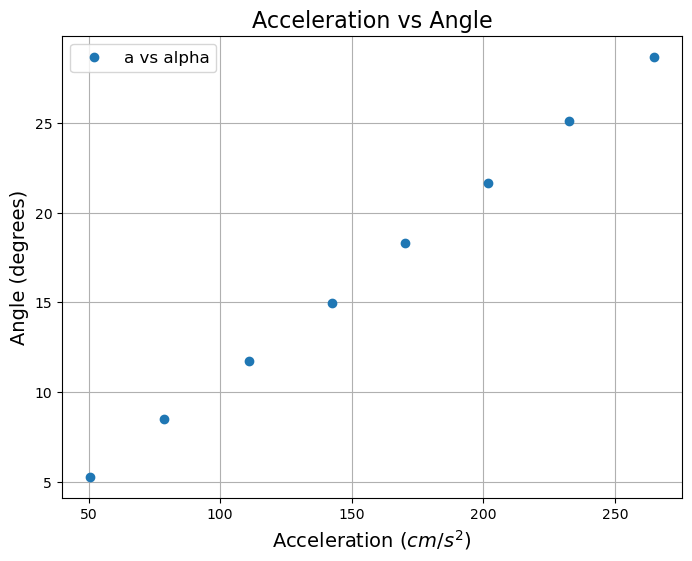

50.6485063191355
78.67467156458494
110.82620072086887
142.40960997433822
170.326808771466
201.88354006097572
232.34403373288984
264.71551836791906
   alpha         acc     err_a  red. chi^2  alpha_radians
0   5.29   50.648506  0.077133    8.050758       0.092328
1   8.49   78.674672  0.110666    5.256508       0.148178
2  11.71  110.826201  0.169303    5.172125       0.204378
3  14.97  142.409610  0.200224    3.525020       0.261276
4  18.28  170.326809  0.343950    6.617393       0.319046
5  21.65  201.883540  0.404729    5.558046       0.377864
6  25.11  232.344034  0.702384   11.151402       0.438252
7  28.67  264.715518  0.558513    4.596161       0.500386


In [74]:
plt.figure(figsize=(8, 6))
plt.plot(results_df['acc'], results_df['alpha'], 'o', label='a vs alpha')
plt.xlabel('Acceleration ($cm$/$s^2$)', fontsize=14)
plt.ylabel('Angle (degrees)', fontsize=14)
plt.title('Acceleration vs Angle', fontsize=16)
plt.legend(fontsize=12)
plt.grid()
plt.savefig('geenfit.png')
plt.show()
for i in np.array(results_df['acc']):
    print(i)
print(results_df)

Fit $B$ (angle_model)

In [71]:
delta_alpha = [0.00926, 0.00932, 0.00941, 0.00953, 0.00967, 0.00983, 0.01, 0.01]

def angle_model(a, B):
    alpha = np.arcsin((a*B) / g)
    return alpha

model = Model(angle_model)    
params = model.make_params(B=1)
result = model.fit(np.radians(np.array(results_df['alpha'])), params , a = np.array(results_df['acc']), weights = 1 / np.array(delta_alpha))

fitted_B = result.params['B'].value
fitted_B_error = result.params['B'].stderr
print(result.fit_report())

[[Model]]
    Model(angle_model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 9
    # data points      = 8
    # variables        = 1
    chi-square         = 0.47185788
    reduced chi-square = 0.06740827
    Akaike info crit   = -20.6441519
    Bayesian info crit = -20.5647104
    R-squared          = -2.32084848
[[Variables]]
    B:  1.78969769 +/- 0.00473749 (0.26%) (init = 1)


Plot $\alpha$ and $a$ with fit (axes flipped)

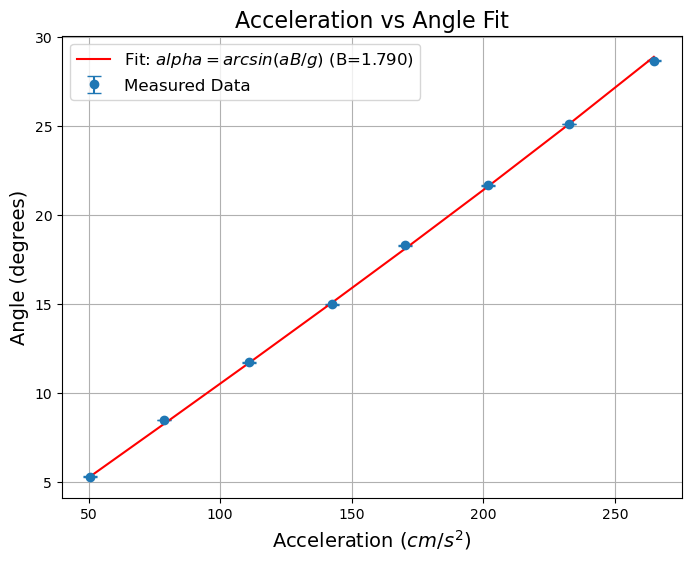

In [72]:
acc_fine = np.linspace(results_df['acc'].min(), results_df['acc'].max(), 100)
fitted_alpha = angle_model(results_df['acc'], fitted_B)

# Plot data and the fit
plt.figure(figsize=(8, 6))
plt.errorbar(
    results_df['acc'],
    results_df['alpha'],
    yerr=delta_alpha,
    fmt='o',
    label='Measured Data',
    capsize=5
)
plt.plot(results_df['acc'], np.degrees(fitted_alpha), 'r-', label=f'Fit: $alpha = arcsin(aB/g)$ (B={fitted_B:.3f})')
plt.xlabel('Acceleration ($cm$/$s^2$)', fontsize=14)
plt.ylabel('Angle (degrees)', fontsize=14)
plt.title('Acceleration vs Angle Fit', fontsize=16)
plt.legend(fontsize=12)
plt.grid()
plt.savefig('fit_as_gedraaid.png')
plt.show()